# Image Classification Model Training and Evaluation

## Import Packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import os
import numpy as np
import shutil
import random
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

In [4]:
# mount drive to access the project
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
project_folder = "/content/drive/My Drive/w210_project/"
%cd $project_folder

/content/drive/My Drive/w210_project


In [6]:
data_folder = "/content/drive/My Drive/w210_project/dataset/classification/"
models_folder = "/content/drive/My Drive/w210_project/models/classification/"
all_images_folder = "all_images/"


In [7]:
MODEL_NAME = "enb7_solar_classifier_model.h5"
EN_MODEL = 'b7'
BATCH_SIZE = 16
BASELINE_MODEL_NAME = 'baseline_classifier_model.h5'
BEST_MODEL = models_folder+'/best_model/enb7_solar_classifier_model.h5'
CURRENT_MODEL = models_folder+MODEL_NAME
LOG_DIR = '/content/drive/My Drive/w210_project/classification_logs/tensorboard_jun28/'

#en_model = EN_MODEL
params_dict = {
        # Coefficients:   res
        'b0': (224, 224),
        'b1': (240, 240),
        'b2': (260, 260),
        'b3': (300, 300),
        'b4': (380, 380),
        'b5': (456, 456),
        'b6': (528, 528),
        'b7': (600, 600),
        'b8': (672, 672),
        'l2': (800, 800),
    }

inputsize = params_dict[EN_MODEL]
IMG_SIZE = inputsize

## Setup data


### Create train, val, test folders

In [ ]:
# copy images of all zoom levels and sizes into all_images folder
def copy_over_all_images(from_folder):
  src_folder = data_folder + from_folder
  to_folder = data_folder + all_images_folder
  
  print(src_folder)
  print(to_folder)
  if not os.path.exists(to_folder):
    os.makedirs(to_folder)

  classes_dir = ['solar', 'no_solar'] # two classes
  for cls in classes_dir:
    if not os.path.exists(to_folder+cls):
      os.makedirs(to_folder+cls)

    # get all files under a class folder
    allFileNames = os.listdir(src_folder + cls)
    allFileNames = [src_folder + cls +'/'+ name for name in allFileNames]
    #print(allFileNames)

    # Copy over images of a particular class to "all_images/"
    for name in allFileNames:
      path, filename = os.path.split(name)
      #print(filename)
      dest_filename = os.path.join(to_folder+cls, filename)
      #print("Destination file: {}".format(dest_filename))

      if os.path.exists(dest_filename):
        #print("dest file exists {}".format(dest_filename))
        dest_name, extension = os.path.splitext(dest_filename)
        dest_filename = dest_name + "_" + str(1) + extension
        #print("New dest filename: {}".format(dest_filename))
        
      shutil.copy(name, dest_filename)


In [ ]:
files = "./all_images/no_solar/" + "*_1.png"
print(files)
%ls $files

./all_images/no_solar/*_1.png
ls: cannot access './all_images/no_solar/*_1.png': No such file or directory


In [ ]:
#copy_over_all_images("zoom20_size600_images/")
#copy_over_all_images("zoom21_size600_images/")
#copy_over_all_images("zoom21_size416_images/")
#copy_over_all_images("zoom20_size600_bigcities_images/")
#copy_over_all_images("zoom21_size600_bigcities_images/")

/content/drive/My Drive/w210_project/dataset/classification/zoom20_size600_images/
/content/drive/My Drive/w210_project/dataset/classification/all_images/
/content/drive/My Drive/w210_project/dataset/classification/zoom21_size600_images/
/content/drive/My Drive/w210_project/dataset/classification/all_images/
/content/drive/My Drive/w210_project/dataset/classification/zoom21_size416_images/
/content/drive/My Drive/w210_project/dataset/classification/all_images/
/content/drive/My Drive/w210_project/dataset/classification/zoom20_size600_bigcities_images/
/content/drive/My Drive/w210_project/dataset/classification/all_images/
/content/drive/My Drive/w210_project/dataset/classification/zoom21_size600_bigcities_images/
/content/drive/My Drive/w210_project/dataset/classification/all_images/


In [ ]:
folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom21_size600_images/solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom21_size600_images/no_solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom20_size600_images/solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom20_size600_images/no_solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom21_size416_images/solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom21_size416_images/no_solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom20_size600_bigcities_images/solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom20_size600_bigcities_images/no_solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom21_size600_bigcities_images/solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/zoom21_size600_bigcities_images/no_solar/"
!ls $folder | wc -l

178
219
181
180
137
78
90
183
90
91


In [ ]:
# Calculate class balance TEST
%cd $data_folder

solar_count = !ls ./all_images/solar/ | wc -l
no_solar_count = !ls ./all_images/no_solar/ | wc -l
ratio = eval(solar_count[0]) / (eval(solar_count[0]) + eval(no_solar_count[0]))

print("Solar images count: {}".format(solar_count))
print("Non-Solar images count: {}".format(no_solar_count))
print("Ratio of solar images: {}".format(ratio))

#!ls ./all_images/solar/

/content/drive/My Drive/w210_project/dataset/classification
Solar images count: ['646']
Non-Solar images count: ['749']
Ratio of solar images: 0.46308243727598564


In [ ]:
%cd $project_folder

/content/drive/My Drive/w210_project


In [ ]:
# create folders for train, validation and test data

def create_train_val_test_folders(): 
  root_dir = data_folder # data root path
  classes_dir = ['solar', 'no_solar'] # two classes

  val_ratio = 0.15
  test_ratio = 0.05

  for cls in classes_dir:
      os.makedirs(root_dir +'train/' + cls)
      os.makedirs(root_dir +'val/' + cls)
      os.makedirs(root_dir +'test/' + cls)

      # Creating partitions of the data after shuffling
      src = root_dir + all_images_folder + cls 
      print(src)
      
      # get all files under a class folder
      allFileNames = os.listdir(src)
      np.random.shuffle(allFileNames)
      train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                                int(len(allFileNames)* (1 - test_ratio))])


      train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
      val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
      test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

      print('Total images: ', len(allFileNames))
      print('Training: ', len(train_FileNames))
      print('Validation: ', len(val_FileNames))
      print('Testing: ', len(test_FileNames))

      # Copy-pasting images
      for name in train_FileNames:
          shutil.copy(name, root_dir +'train/' + cls)

      for name in val_FileNames:
          shutil.copy(name, root_dir +'val/' + cls)

      for name in test_FileNames:
          shutil.copy(name, root_dir +'test/' + cls)

create_train_val_test_folders()

/content/drive/My Drive/w210_project/dataset/classification/all_images/solar
Total images:  646
Training:  516
Validation:  97
Testing:  33
/content/drive/My Drive/w210_project/dataset/classification/all_images/no_solar
Total images:  749
Training:  599
Validation:  112
Testing:  38


In [ ]:
# Split and copy images from a given folder to the folders for train, 
# validation and test data under root data folder

def copy_to_train_val_test_folders(from_folder): 
  root_dir = data_folder # data root path where tarin, var and test folders are
  print(root_dir)
  classes_dir = ['solar', 'no_solar'] # two classes

  val_ratio = 0.15
  test_ratio = 0.05

  for cls in classes_dir:
      #os.makedirs(root_dir +'train/' + cls)
      #os.makedirs(root_dir +'val/' + cls)
      #os.makedirs(root_dir +'test/' + cls)

      # Creating partitions of the data after shuffling
      src = root_dir + from_folder + cls 
      print(src)
      
      # get all files under a class folder
      allFileNames = os.listdir(src)
      np.random.shuffle(allFileNames)
      train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                                int(len(allFileNames)* (1 - test_ratio))])


      train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
      val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
      test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

      print('Total images: ', len(allFileNames))
      print('Training: ', len(train_FileNames))
      print('Validation: ', len(val_FileNames))
      print('Testing: ', len(test_FileNames))

      # Copy-pasting images
      for name in train_FileNames:
          #print(name)
          shutil.copy(name, root_dir +'train/' + cls)

      for name in val_FileNames:
          shutil.copy(name, root_dir +'val/' + cls)

      for name in test_FileNames:
          shutil.copy(name, root_dir +'test/' + cls)

#copy_to_train_val_test_folders("zoom20_size600_bigcities_images/")
#copy_to_train_val_test_folders("zoom21_size600_bigcities_images/")

/content/drive/My Drive/w210_project/dataset/classification/
/content/drive/My Drive/w210_project/dataset/classification/zoom20_size600_bigcities_images/solar
Total images:  91
Training:  72
Validation:  14
Testing:  5
/content/drive/My Drive/w210_project/dataset/classification/zoom20_size600_bigcities_images/no_solar
Total images:  183
Training:  146
Validation:  27
Testing:  10
/content/drive/My Drive/w210_project/dataset/classification/
/content/drive/My Drive/w210_project/dataset/classification/zoom21_size600_bigcities_images/solar
Total images:  91
Training:  72
Validation:  14
Testing:  5
/content/drive/My Drive/w210_project/dataset/classification/zoom21_size600_bigcities_images/no_solar
Total images:  91
Training:  72
Validation:  14
Testing:  5


In [ ]:
folder = "/content/drive/My\ Drive/w210_project/dataset/classification/train/solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/train/no_solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/val/solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/val/no_solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/test/solar/"
!ls $folder | wc -l

folder = "/content/drive/My\ Drive/w210_project/dataset/classification/test/no_solar/"
!ls $folder | wc -l

516
599
97
112
33
38


## Set up Data Folders

In [16]:
# use 80% of the data as training and 20% as the validation data
data_dir = data_folder + all_images_folder

train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=123,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir,
                                                  shuffle=True,
                                                  validation_split=0.2,
                                                  subset="validation",
                                                  seed=123,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 1395 files belonging to 2 classes.
Using 1116 files for training.
Found 1395 files belonging to 2 classes.
Using 279 files for validation.


In [19]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

print(train_dataset.class_names)

(16, 600, 600, 3)
(16,)
['no_solar', 'solar']


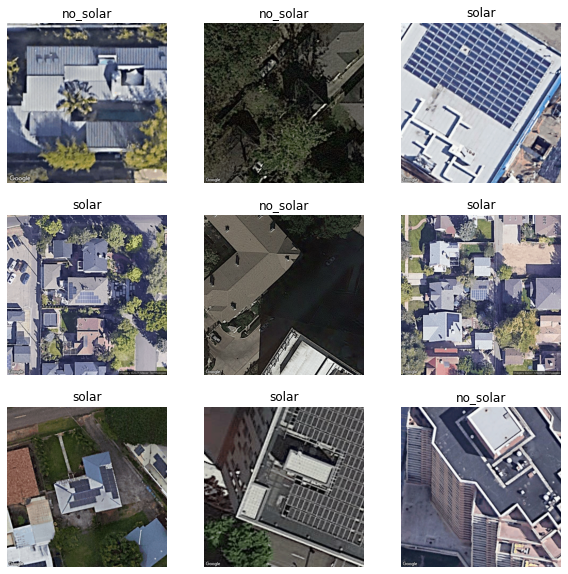

In [10]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [11]:
labels

<tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0], dtype=int32)>

## Configure datasets for performance

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
  tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),
  tf.keras.layers.experimental.preprocessing.RandomCrop(width=IMG_SIZE[0], height=IMG_SIZE[1]),
  #tf.keras.layers.experimental.preprocessing.Resizing(width=IMG_SIZE[0], height=IMG_SIZE[1]),
])

In [ ]:
# view augmented images
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


## Functions

In [18]:
def build_baseline_model():
  model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0 to 1, where 0 is for the first class 
    # and 1 for the other class
    tf.keras.layers.Dense(1)
  ])

  learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model

def train_baseline_model(model, train_ds, val_ds, epochs):  

  # stop learining as metric on validatopn stop increasing
  early_stopping = EarlyStopping(patience=20, verbose=1, mode = 'auto') 
  mode_autosave = ModelCheckpoint(models_folder+BASELINE_MODEL_NAME, monitor='val_accuracy', 
                                   mode ='max', save_best_only=True, verbose=1, save_freq='epoch')

  callbacks = [mode_autosave, early_stopping]
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, 
    callbacks = callbacks
  )
  return model, history

def set_callbacks(model_name=MODEL_NAME, log_dir=LOG_DIR):
  # reduces learning rate on plateau
  lr_reducer = ReduceLROnPlateau(factor=0.1,
                                cooldown= 10,
                                patience=10,verbose =1,
                                min_lr=0.1e-5)
  mode_autosave = ModelCheckpoint(models_folder+model_name, monitor='val_accuracy', 
                                    mode ='max', save_best_only=True, verbose=1, save_freq='epoch')

  # stop learining as metric on validatopn stop increasing
  early_stopping = EarlyStopping(patience=30, verbose=1, mode = 'auto') 

  # tensorboard for monitoring logs
  tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0,
                            write_graph=True, write_images=False)

  callbacks = [mode_autosave, lr_reducer, tensorboard, early_stopping]
  return callbacks

def build_efnet_base_and_model():
  IMG_SHAPE = IMG_SIZE + (3,)
  base_model = tf.keras.applications.EfficientNetB7(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
  # freeze the convolutional base
  base_model.trainable = False

  # get preprocess_input function
  preprocess_input = tf.keras.applications.efficientnet.preprocess_input

  # add a GlobalAveragePooling2D layer
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add a prediction layer
  prediction_layer = tf.keras.layers.Dense(1)

  # prepare model
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  # compile the model
  base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  return base_model, model

def train_efnet_model(model, train_dataset=train_dataset, validation_data=validation_dataset, initial_epochs=50):

  # stop learining as metric on validatopn stop increasing
  early_stopping = EarlyStopping(patience=15, verbose=1, mode = 'auto') 
  callbacks = [early_stopping]

  # fit model with just top layer training
  history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)
  return model, history

def build_model_for_finetuning(base_model, model, fine_tune_at = 500):
  base_learning_rate = 0.0001
  base_model.trainable = True

  # Let's take a look to see how many layers are in the base model
  print("Number of layers in the base model: ", len(base_model.layers))

  # Fine-tune from this layer onwards
  #fine_tune_at = 500
  print("Fine tuning from the layer: ", fine_tune_at)

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
  
  # compile the model with lower learning rate
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
  
  print("Number of trainable variables in the model: ", len(model.trainable_variables))
  return model

def finetune_efnet_model(model, callbacks, history, train_dataset=train_dataset, validation_data=validation_dataset, initial_epochs=50):
  fine_tune_epochs = 50
  total_epochs =  initial_epochs + fine_tune_epochs

  history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=callbacks)
  return model, history_fine

def plot_model_training(history):
  # plot history
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


def plot_fine_tuning(history, history_fine, initial_epochs=50):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  acc += history_fine.history['accuracy']
  val_acc += history_fine.history['val_accuracy']

  loss += history_fine.history['loss']
  val_loss += history_fine.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.ylim([0.8, 1])
  plt.plot([initial_epochs-1,initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.ylim([0, 1.0])
  plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

def evaluate_model(model_name_with_path, val_dataset, message):
  # load model 
  model = keras.models.load_model(model_name_with_path)

  loss, accuracy = model.evaluate(val_dataset)
  print('Validation accuracy for {}:'.format(message), accuracy)
  
  # predict on batches of images
  predictions = []
  labels = []
  for image_batch, labels_batch in val_dataset.as_numpy_iterator():
    batch_predictions = model.predict_on_batch(image_batch).flatten()
    predictions.append(batch_predictions)
    labels.append(labels_batch)
    
  predictions = np.concatenate(predictions)
  labels = np.concatenate(labels)

  # Apply a sigmoid since our model returns logits
  predictions = tf.nn.sigmoid(predictions)
  predictions = tf.where(predictions < 0.5, 0, 1)

  print("========== Classification Report  =============")
  print(classification_report(labels, predictions))

  print("========== Confusion Matrix  =============")
  print(confusion_matrix(labels, predictions))

  return labels, predictions

def get_incorrect_prediction_indices(labels, predictions):
  incorrect_indices = np.argwhere(labels != predictions)
  return incorrect_indices

def model_accuracy(model_name_with_path, val_dataset):
  model = keras.models.load_model(model_name_with_path)
  loss, accuracy = model.evaluate(val_dataset)
  return accuracy

# Error analysis on validation data prediction
def show_wrong_prediction_images(model, eval_dataset):
  class_names = eval_dataset.class_names

  for image, label in eval_dataset.as_numpy_iterator():
    predicted = model.predict(image)
    predicted = tf.nn.sigmoid(predicted)
    predicted = tf.where(predicted < 0.5, 0, 1)
    predicted = predicted.numpy()[0][0]
    label = label[0]

    if (label != predicted):
      print(label)
      print(predicted)
      plt.imshow(image.astype("uint8").squeeze(0))
      plt.title(class_names[label])
      plt.axis("off")
      plt.show()
      

def plot_confusion_matrix(best_labels, best_predictions):
  cf_matrix = confusion_matrix(best_labels, best_predictions)
  categories = ['No-Solar', 'Solar']
  ax = sns.heatmap(cf_matrix, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=categories, annot=True, cbar=False)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  ax.xaxis.tick_top() # x axis on top
  ax.xaxis.set_label_position('top')

## Build and Train Baseline model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 600, 600, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 600, 600, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 300, 300, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 300, 300, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 64)       

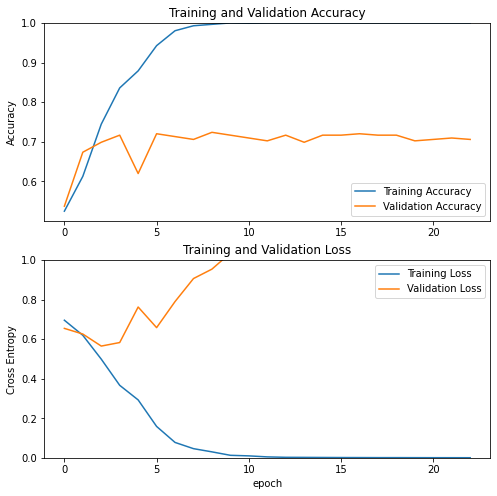

18/18 [==============================] - 1s 22ms/step - loss: 0.9544 - accuracy: 0.7240
Validation accuracy for Baseline Model: 0.7240143418312073
========== Classification Report  =============
              precision    recall  f1-score   support

           0       0.80      0.65      0.71       150
           1       0.66      0.81      0.73       129

    accuracy                           0.72       279
   macro avg       0.73      0.73      0.72       279
weighted avg       0.73      0.72      0.72       279

========== Confusion Matrix  =============
[[ 97  53]
 [ 25 104]]


In [ ]:
baseline_epochs = 50
baseline_model = build_baseline_model()
baseline_model.summary()

baseline_model, history = train_baseline_model(baseline_model, train_dataset, validation_dataset, baseline_epochs)
plot_model_training(history)

# evaluate baseline model
evaluate_model(models_folder+BASELINE_MODEL_NAME, validation_dataset, "Baseline Model")

## Build Base and Fine-Tune EfficientNetB7 for SolarPanels

In [ ]:
######## call the functions to build base and fine-tune efnet for solar panels ##########

base_model, model = build_efnet_base_and_model()
model, history_base = train_efnet_model(model, 50)

Epoch 1/50
70/70 [==============================] - 66s 580ms/step - loss: 0.7146 - accuracy: 0.5287 - val_loss: 0.6895 - val_accuracy: 0.5412
Epoch 2/50
70/70 [==============================] - 35s 501ms/step - loss: 0.6868 - accuracy: 0.5358 - val_loss: 0.6613 - val_accuracy: 0.5376
Epoch 3/50
70/70 [==============================] - 35s 501ms/step - loss: 0.6611 - accuracy: 0.5394 - val_loss: 0.6394 - val_accuracy: 0.5699
Epoch 4/50
70/70 [==============================] - 35s 501ms/step - loss: 0.6455 - accuracy: 0.5493 - val_loss: 0.6184 - val_accuracy: 0.5735
Epoch 5/50
70/70 [==============================] - 35s 501ms/step - loss: 0.6287 - accuracy: 0.5573 - val_loss: 0.6030 - val_accuracy: 0.6344
Epoch 6/50
70/70 [==============================] - 35s 501ms/step - loss: 0.6169 - accuracy: 0.5824 - val_loss: 0.5931 - val_accuracy: 0.6738
Epoch 7/50
70/70 [==============================] - 35s 501ms/step - loss: 0.5969 - accuracy: 0.6120 - val_loss: 0.5798 - val_accuracy: 0.6595

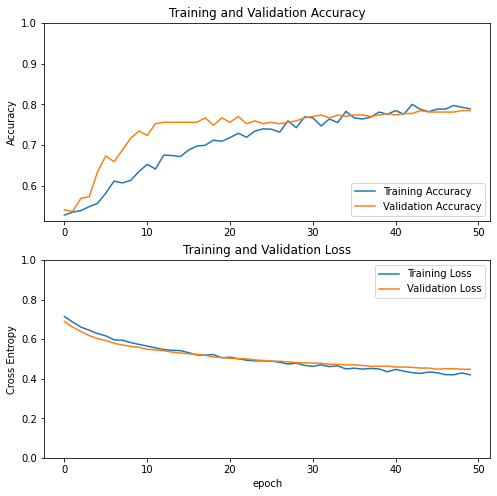

In [ ]:
plot_model_training(history_base)

In [ ]:
# fine-tune model
callbacks = set_callbacks()
model = build_model_for_finetuning(base_model, model)
model, history_fine = finetune_efnet_model(model, callbacks, history_base)

Number of layers in the base model:  813
Number of trainable variables in the model:  233


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 50/100
70/70 [==============================] - 87s 884ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.0764 - val_accuracy: 0.9713

Epoch 00050: val_accuracy improved from -inf to 0.97133, saving model to /content/drive/My Drive/w210_project/models/classification/enb7_solar_classifier_model.h5
Epoch 51/100
70/70 [==============================] - 51s 733ms/step - loss: 0.0015 - accuracy: 0.9991 - val_loss: 0.0571 - val_accuracy: 0.9821

Epoch 00051: val_accuracy improved from 0.97133 to 0.98208, saving model to /content/drive/My Drive/w210_project/models/classification/enb7_solar_classifier_model.h5
Epoch 52/100
70/70 [==============================] - 51s 733ms/step - loss: 4.2516e-04 - accuracy: 1.0000 - val_loss: 0.0706 - val_accuracy: 0.9785

Epoch 00052: val_accuracy did not improve from 0.98208
Epoch 53/100
70/70 [==============================] - 51s 734ms/step - loss: 5.3316e-04 - accuracy: 1.0000 - val_loss: 0.0720 - val_accuracy: 0.9785

Epoch 00053: val_accurac

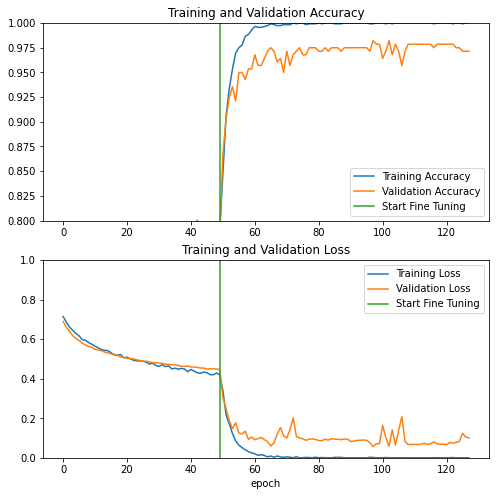

18/18 [==============================] - 12s 388ms/step - loss: 0.0571 - accuracy: 0.9821
Validation accuracy for Current Model: 0.9820788502693176
========== Classification Report  =============
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       150
           1       0.98      0.98      0.98       129

    accuracy                           0.98       279
   macro avg       0.98      0.98      0.98       279
weighted avg       0.98      0.98      0.98       279

========== Confusion Matrix  =============
[[147   3]
 [  2 127]]


In [ ]:
# plot base training and fine-tuning
plot_fine_tuning(history_base, history_fine)

## Evaluate Current Model

In [68]:
# Evaluate Current Model
current_labels, current_predictions = evaluate_model(models_folder+MODEL_NAME, validation_dataset, "Current Model")

18/18 [==============================] - 18s 749ms/step - loss: 0.0571 - accuracy: 0.9821
Validation accuracy for Current Model: 0.9820788502693176
========== Classification Report  =============
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       150
           1       0.98      0.98      0.98       129

    accuracy                           0.98       279
   macro avg       0.98      0.98      0.98       279
weighted avg       0.98      0.98      0.98       279

========== Confusion Matrix  =============
[[147   3]
 [  2 127]]


## Evaluate Best Model

In [19]:
### Evaluate Best Model to compare with the current model
best_labels, best_predictions = evaluate_model(BEST_MODEL, validation_dataset, "Best Model")

18/18 [==============================] - 20s 774ms/step - loss: 0.0255 - accuracy: 0.9892
Validation accuracy for Best Model: 0.9892473220825195
========== Classification Report  =============
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       150
           1       1.00      0.99      1.00       129

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279

========== Confusion Matrix  =============
[[150   0]
 [  1 128]]


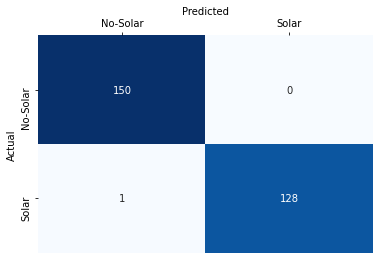

In [44]:
# plot best model confusion matrix
plot_confusion_matrix(best_labels, best_predictions)

## Shard dataset and train on portions of data

In [ ]:
model_name = f'enb7_solar_classifier_model_shard{i}.h5'
model_name

'enb7_solar_classifier_model_shard0.h5'

In [ ]:
size_accuracy = []
for i in range(5, 9):
  results_dict = {}
  val_split = (10-i)/10
  print(f'######### Iteration {i} #############')
  #train_dataset_part = train_dataset.shard(num_shards=i, index=0)
  train_dataset_part = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             validation_split=val_split,
                                             subset="training",
                                             seed=123,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
  train_dataset_part = train_dataset_part.cache().prefetch(buffer_size=AUTOTUNE)

  model_name = f'enb7_solar_classifier_model_shard{i}.h5'

  base_model, model = build_efnet_base_and_model()
  # train with just last prediction layer
  model, history_base = train_efnet_model(model, train_dataset=train_dataset_part)

  callbacks = set_callbacks(model_name=model_name, 
                            log_dir=f'/content/drive/My Drive/w210_project/classification_logs/shard_{i}')
  
  model = build_model_for_finetuning(base_model, model, fine_tune_at=520)
  # fine tune some of the layers of efnet
  model, history_fine = finetune_efnet_model(model, callbacks, history_base, train_dataset=train_dataset_part)
  #plot_fine_tuning(history_base, history_fine)

  accuracy = model_accuracy(models_folder+model_name, validation_dataset)
  #print(f'Dataset size {len(train_dataset_part)}')
  print(f'Accuracy {accuracy}')
  results_dict = results_dict.update({'Dataset size':len(train_dataset_part), 'Model accuracy':accuracy})
  size_accuracy.append(results_dict)

print(size_accuracy)


######### Iteration 5 #############
Found 1395 files belonging to 2 classes.
Using 698 files for training.
Epoch 1/50
44/44 [==============================] - 72s 1s/step - loss: 0.6831 - accuracy: 0.5587 - val_loss: 0.6597 - val_accuracy: 0.5376
Epoch 2/50
44/44 [==============================] - 48s 1s/step - loss: 0.6624 - accuracy: 0.5587 - val_loss: 0.6452 - val_accuracy: 0.5412
Epoch 3/50
44/44 [==============================] - 48s 1s/step - loss: 0.6504 - accuracy: 0.5645 - val_loss: 0.6330 - val_accuracy: 0.5556
Epoch 4/50
44/44 [==============================] - 48s 1s/step - loss: 0.6385 - accuracy: 0.5645 - val_loss: 0.6231 - val_accuracy: 0.5663
Epoch 5/50
44/44 [==============================] - 48s 1s/step - loss: 0.6217 - accuracy: 0.5745 - val_loss: 0.6136 - val_accuracy: 0.5878
Epoch 6/50
44/44 [==============================] - 48s 1s/step - loss: 0.6140 - accuracy: 0.5931 - val_loss: 0.6050 - val_accuracy: 0.6093
Epoch 7/50
44/44 [==============================] - 4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 50/100
44/44 [==============================] - 101s 2s/step - loss: 0.4005 - accuracy: 0.8066 - val_loss: 0.3786 - val_accuracy: 0.8244

Epoch 00050: val_accuracy improved from -inf to 0.82437, saving model to /content/drive/My Drive/w210_project/models/classification/enb7_solar_classifier_model_shard5.h5
Epoch 51/100
44/44 [==============================] - 73s 2s/step - loss: 0.2767 - accuracy: 0.8768 - val_loss: 0.3016 - val_accuracy: 0.8674

Epoch 00051: val_accuracy improved from 0.82437 to 0.86738, saving model to /content/drive/My Drive/w210_project/models/classification/enb7_solar_classifier_model_shard5.h5
Epoch 52/100
44/44 [==============================] - 73s 2s/step - loss: 0.1950 - accuracy: 0.9155 - val_loss: 0.2547 - val_accuracy: 0.8817

Epoch 00052: val_accuracy improved from 0.86738 to 0.88172, saving model to /content/drive/My Drive/w210_project/models/classification/enb7_solar_classifier_model_shard5.h5
Epoch 53/100
44/44 [==============================] - 

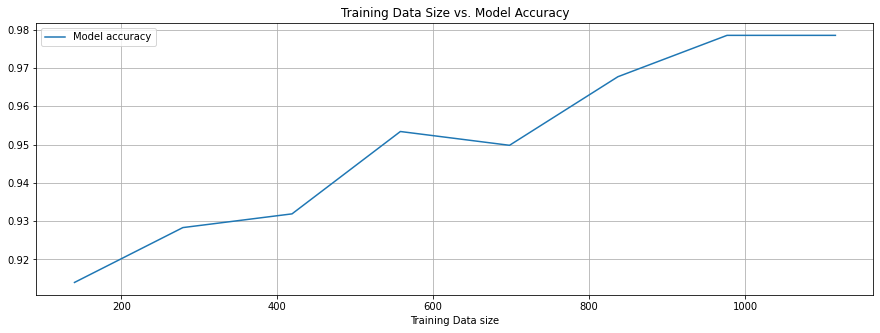

In [ ]:
import pandas as pd

#df = pd.DataFrame([size_accuracy])
sizes = [140, 279, 419, 558, 698, 837, 977, 1116]  
accuracies = [0.9140, 0.92832, 0.9319, 0.9534, 0.9498, 0.9677, 0.9785, 0.9785]
  
# Calling DataFrame constructor after zipping
df = pd.DataFrame(list(zip(sizes, accuracies)),
               columns =['Training Data size', 'Model accuracy'])
#plt.plot(df)
#plt.show()
df.plot(x='Training Data size', y='Model accuracy', figsize=(15, 5), grid=True, title='Training Data Size vs. Model Accuracy')

## Hyperparameter Tuning using Keras Tuner

In [ ]:
# Hyperparameter tuning

## Error Analysis on Predicted Results

In [66]:
eval_dataset = image_dataset_from_directory(data_dir,
                                                  shuffle=True,
                                                  validation_split=0.2,
                                                  subset="validation",
                                                  seed=123,
                                                  batch_size=1,
                                                  image_size=IMG_SIZE)
# load model 
model = keras.models.load_model(CURRENT_MODEL)

Found 1395 files belonging to 2 classes.
Using 279 files for validation.


1
0


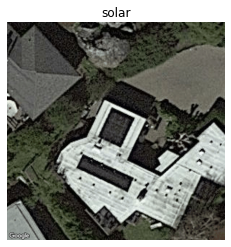

0
1


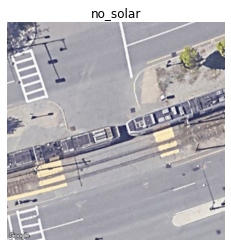

0
1


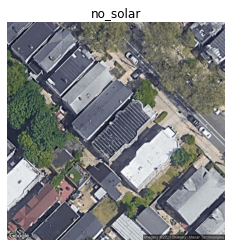

0
1


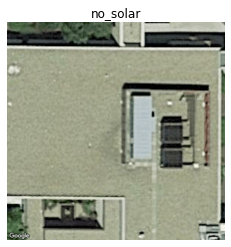

1
0


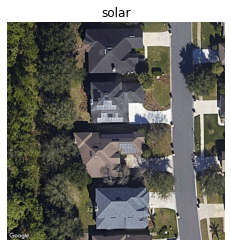

In [67]:
show_wrong_prediction_images(model, eval_dataset)

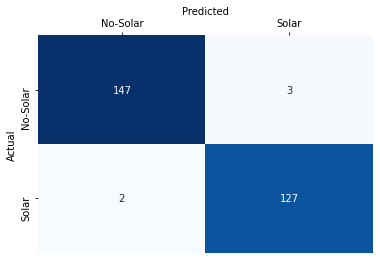

In [69]:
plot_confusion_matrix(current_labels, current_predictions)

####################################################################
############# Delete code after this #########################
